Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [81]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules or 'jupyter_client' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [82]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [40]:
df.shape

(23040, 21)

In [41]:
df.describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,23040.000000,23040.000000,23040.000000,0.0,23039.000000,23039.000000,23039.000000,23039.000000,2.303900e+04,23005.000000,23040.000000,2.304000e+04
mean,2.978993,4459.116493,353.948481,NaN,10791.186987,1.827423,0.286514,2.320891,3.508555e+03,1819.671724,1.624479,1.328133e+06
std,1.258951,3713.269887,628.025255,NaN,1103.414210,10.090432,5.778224,12.070554,2.218610e+04,488.376571,0.803898,1.025394e+07
min,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,-148.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,2.000000,1341.000000,22.000000,NaN,10306.000000,0.000000,0.000000,1.000000,4.940000e+02,1920.000000,1.000000,0.000000e+00
50%,3.000000,3546.000000,49.000000,NaN,11211.000000,1.000000,0.000000,1.000000,1.356000e+03,1940.000000,1.000000,4.550000e+05
75%,4.000000,6673.750000,375.000000,NaN,11360.000000,2.000000,0.000000,2.000000,2.280000e+03,1965.000000,2.000000,8.750000e+05
max,5.000000,16350.000000,9057.000000,NaN,11697.000000,750.000000,570.000000,755.000000,1.303935e+06,2019.000000,4.000000,8.500000e+08


In [42]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [83]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [84]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

1. Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [85]:
# start of my work
# pre-processing of the data
# Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.
cond_1 = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')
cond_2 = (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)
df_sub = df[cond_1 & cond_2]
df_sub.shape

(3151, 21)

In [99]:
df_sub['BUILDING_CLASS_CATEGORY'].sample(20)

13728    01 ONE FAMILY DWELLINGS
2323     01 ONE FAMILY DWELLINGS
162      01 ONE FAMILY DWELLINGS
10864    01 ONE FAMILY DWELLINGS
9407     01 ONE FAMILY DWELLINGS
4960     01 ONE FAMILY DWELLINGS
21877    01 ONE FAMILY DWELLINGS
4249     01 ONE FAMILY DWELLINGS
9661     01 ONE FAMILY DWELLINGS
4699     01 ONE FAMILY DWELLINGS
20033    01 ONE FAMILY DWELLINGS
15677    01 ONE FAMILY DWELLINGS
17183    01 ONE FAMILY DWELLINGS
9028     01 ONE FAMILY DWELLINGS
10821    01 ONE FAMILY DWELLINGS
789      01 ONE FAMILY DWELLINGS
13282    01 ONE FAMILY DWELLINGS
12198    01 ONE FAMILY DWELLINGS
9512     01 ONE FAMILY DWELLINGS
20197    01 ONE FAMILY DWELLINGS
Name: BUILDING_CLASS_CATEGORY, dtype: object


2. Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.


In [49]:
df_sub.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [95]:
# train / test split
# feature engineering, create datetime from SALE_DATE string

import datetime
# df_sub['SALE_DATE'].sample(20)
# print('test', datetime.datetime(2019, 1, 1))
print('test', df_sub['SALE_DATE'].iloc[0])
print('test', df_sub['SALE_DATE'].iloc[999])
# print('test', datetime.datetime.strptime(df_sub['SALE_DATE'].iloc[0], format_str))

def str_to_datetime(str_input):
    format_str = '%m/%d/%Y'
    return datetime.datetime.strptime(str_input, format_str)
print('test', str_to_datetime(df_sub['SALE_DATE'].iloc[10]))
df_sub['SALE_DATE_DT'] = df_sub['SALE_DATE'].apply(str_to_datetime)
df_sub['SALE_DATE_DT'].head()

test 01/01/2019
test 02/04/2019
test 2019-01-02 00:00:00
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


44    2019-01-01
61    2019-01-01
78    2019-01-02
108   2019-01-02
111   2019-01-02
Name: SALE_DATE_DT, dtype: datetime64[ns]

In [97]:
# split train / test
cond_train = (df_sub['SALE_DATE_DT'] > datetime.datetime(2018, 12, 31)) & (df_sub['SALE_DATE_DT'] < datetime.datetime(2019, 4, 1))
cond_test = (df_sub['SALE_DATE_DT'] > datetime.datetime(2019, 3, 31))

train = df_sub[cond_train]
test = df_sub[cond_test]
print('train data', train['SALE_DATE_DT'].sample(10))
print('test data', test['SALE_DATE_DT'].sample(10))

train data 1424    2019-01-09
7736    2019-02-07
15081   2019-03-15
10938   2019-02-25
16435   2019-03-22
15521   2019-03-19
14000   2019-03-12
6273    2019-01-31
8832    2019-02-13
7917    2019-02-08
Name: SALE_DATE_DT, dtype: datetime64[ns]
test data 22829   2019-04-29
22014   2019-04-22
18525   2019-04-02
21373   2019-04-17
19905   2019-04-09
22752   2019-04-29
19254   2019-04-05
22683   2019-04-26
21898   2019-04-19
18739   2019-04-03
Name: SALE_DATE_DT, dtype: datetime64[ns]


3. Do one-hot encoding of categorical features.


In [98]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE,SALE_DATE_DT
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507,2507
unique,5,6,1,2,13,2497,1,887,11,68,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,294 FREEBORN STREET,RP.,"4,000",A1,01/31/2019,2019-01-31 00:00:00
freq,1204,2382,2507,2476,919,2,1,234,919,78,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [105]:
# 'borough' seems to be a good feature and it has 5 uniques values in int
train['BOROUGH'].value_counts()

4    1204
5     662
3     398
2     242
1       1
Name: BOROUGH, dtype: int64

In [110]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    739000.000000
2    473104.623967
3    768734.633166
4    649005.172757
5    537305.802115
Name: SALE_PRICE, dtype: float64

In [111]:
train.groupby('BOROUGH')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
1,1.0,739000.000000,NaN,739000.0,739000.0,739000.0,739000.0,739000.0
2,242.0,473104.623967,184647.130460,108000.0,355000.0,465000.0,550000.0,1750000.0
3,398.0,768734.633166,366138.391194,115000.0,523125.0,676421.5,930000.0,1955000.0
4,1204.0,649005.172757,289512.945057,104000.0,450000.0,601500.0,815000.0,1876000.0
5,662.0,537305.802115,217441.137801,113348.0,415000.0,520000.0,617250.0,1850000.0


In [106]:
# how about neighborhood?
train['NEIGHBORHOOD'].value_counts()
# there are too many other values but since they are not in top 10
# we could go for neighborhood

OTHER                 2382
FLUSHING-NORTH          77
FOREST HILLS            17
BOROUGH PARK            12
ASTORIA                 11
BEDFORD STUYVESANT       8
Name: NEIGHBORHOOD, dtype: int64

In [115]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
NEIGHBORHOOD,,,,,,,,
ASTORIA,11.0,1.001955e+06,365110.014554,232000.0,820250.0,1090000.0,1180000.0,1600000.0
BEDFORD STUYVESANT,8.0,6.215972e+05,366413.760913,189270.0,287500.0,612500.0,860000.0,1128508.0
BOROUGH PARK,12.0,1.008917e+06,340243.284172,600000.0,898250.0,913750.0,988500.0,1850000.0
FLUSHING-NORTH,77.0,8.689417e+05,232499.833916,226667.0,770000.0,845000.0,930000.0,1695000.0
FOREST HILLS,17.0,1.210753e+06,392811.007543,640000.0,875000.0,1122000.0,1490000.0,1876000.0
OTHER,2382.0,6.056645e+05,281268.755315,104000.0,435000.0,550000.0,720000.0,1955000.0


In [107]:
# how about neighborhood?
train['BUILDING_CLASS_AT_PRESENT'].value_counts()

A1    919
A5    779
A2    411
A9    193
A0     67
S1     39
A3     38
A8     31
A6     14
A4     13
S0      1
B2      1
B3      1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64

In [122]:
train['APARTMENT_NUMBER'].isnull().sum()

2506

In [124]:
train['EASE-MENT'].isnull().sum()

2507

In [131]:
# The other non-numeric columns have high cardinality. So let's exclude them from our features for now
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'LAND_SQUARE_FEET', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_PRESENT', 'SALE_DATE', 'SALE_DATE_DT']
etc = ['EASE-MENT', 'APARTMENT_NUMBER']
features = train.columns.drop([target] + high_cardinality + etc)
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [132]:
# Here's what X_train looks like before encoding
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [133]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1


In [134]:
import category_encoders as ce

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [135]:
X_test_enc.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,...,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
18235,0,0,1,0,0,1,0,0,0,0,...,0,5913,878,10471.0,1.0,0.0,1.0,2272.0,1930.0,1
18239,0,0,1,0,0,1,0,0,0,0,...,0,5488,48,10465.0,1.0,0.0,1.0,720.0,1935.0,1
18244,1,0,0,0,0,1,0,0,0,0,...,0,5936,31,11209.0,1.0,0.0,1.0,2210.0,1925.0,1
18280,1,0,0,0,0,1,0,0,0,0,...,0,7813,24,11210.0,1.0,0.0,1.0,1520.0,1915.0,1
18285,1,0,0,0,0,1,0,0,0,0,...,0,8831,160,11229.0,1.0,0.0,1.0,840.0,1925.0,1


In [136]:
X_test_enc.shape

(644, 23)

In [137]:
X_test_enc.columns

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

4. Do feature selection with SelectKBest.
5. Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)
6. Get mean absolute error for the test set.
As always, commit your notebook to your fork of the GitHub repo.

In [138]:
# TODO: Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)

# SelectKBest has a similar API to what we've seen before.
# IMPORTANT!
# .fit_transform on the train set
# .transform on test set

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector.fit_transform(X_train_enc, y_train)
X_test_kbest = selector.transform(X_test_enc)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [139]:
X_train_kbest.shape, X_test_kbest.shape

((2507, 15), (644, 15))

In [140]:
X_train_kbest

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        1.325e+03],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        2.001e+03],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        2.043e+03],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        1.807e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        6.210e+02],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        1.163e+03]])

In [141]:
mask = selector.get_support()
mask

array([ True,  True,  True,  True, False,  True,  True, False,  True,
        True, False, False,  True, False,  True, False,  True,  True,
        True,  True,  True, False, False])

In [142]:
X_train_enc.columns[mask]

Index(['BOROUGH_3', 'BOROUGH_4', 'BOROUGH_2', 'BOROUGH_5',
       'NEIGHBORHOOD_OTHER', 'NEIGHBORHOOD_FLUSHING-NORTH',
       'NEIGHBORHOOD_FOREST HILLS', 'NEIGHBORHOOD_BOROUGH PARK',
       'TAX_CLASS_AT_PRESENT_1', 'BLOCK', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET'],
      dtype='object')

In [143]:
X_train_enc.columns[~mask]

Index(['BOROUGH_1', 'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1D', 'LOT', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [161]:
# TODO: How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range(1, X_train_enc.shape[1]+1):
  print(f'{k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_enc, y_train)
  X_test_kbest = selector.transform(X_test_enc)
  model = LinearRegression()
  model.fit(X_train_kbest, y_train)
  y_pred = model.predict(X_test_kbest)
  mae = mean_absolute_error(y_pred, y_test)
  print(f'MAE on test set: ${mae:.2f}')
  mae_list.append(mae)

.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedo

In [162]:
mae_list

[183640.5858012459,
 174495.91534327448,
 175142.67817356435,
 173620.36506521053,
 174228.7197855156,
 174011.32697173842,
 169628.17852770648,
 170425.58748586278,
 169744.84075721275,
 162186.9848578355,
 163540.70748177278,
 161621.69342187417,
 161706.1483886129,
 161706.14838859456,
 161499.3808185521,
 161410.7661456866,
 161988.5193876952,
 162006.2561875129,
 162021.24382728196,
 162021.24382727634,
 162021.2438272786,
 162021.2438272784,
 162021.24382727972]

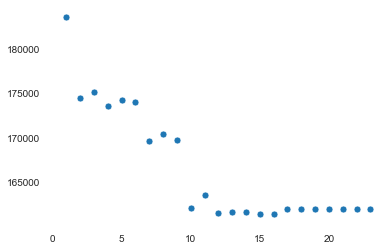

In [145]:
import seaborn as sns

sns.scatterplot(range(1, X_train_enc.shape[1]+1), mae_list)

In [166]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def ridge(alpha):
    """
    Fit & plot a ridge regression model,
    with my df above.

    alpha : positive float, regularization strength
    """

    # Fit linear model
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_enc, y_train)

    # Get linear equation
    m = model.coef_[0].round(2)
    b = model.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'

    # Get predictions
    y_pred = model.predict(X_test_enc)

    mae = mean_absolute_error(y_test, y_pred)
    print('alpha', alpha, 'mae', mae)
   
    
for alpha in range(10):
    ridge(alpha=alpha)

alpha 0 mae 1.5639604754339114e+16
alpha 1 mae 174863.64578581622
alpha 2 mae 184076.30214776477
alpha 3 mae 189436.4387175972
alpha 4 mae 192945.67400567172
alpha 5 mae 195502.58067699833
alpha 6 mae 197404.81612330503
alpha 7 mae 198923.113307624
alpha 8 mae 200154.468671875
alpha 9 mae 201177.37456255953
